# Mammal Ensemble Language Model

This notebook trains a genomic language model on the data prepared in the __Mammal 0 Genomic Data Processing__ notebook. The model structure and training methodology for genomic language models is explained in the [E. coli 2 Genomic Pretraining](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%202%20Genomic%20Pretraining.ipynb) notebook.

This notebook is basically a ton of repetitive code because I had to break the training procedure into multiple chunks over several days.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

In [5]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [6]:
df_valid = pd.read_csv(path/'mammal_val.csv')

In [7]:
df_iter = pd.read_csv(path/'mammal_train.csv', chunksize=1000000)

In [8]:
df = next(df_iter)

In [9]:
df.head()

,Sequence,Source,set
0,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,NCBI Human,train
1,CATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGG...,NCBI Human,train
2,ACCTGCCCCACAGCCTTGCCTGGATTTCTATCTCCCTGGCTTGGTG...,NCBI Human,train
3,CTGGGGAAGCTTACTGTGTCCAAGAGCCTGCTGGGAGGGAAGTCAC...,NCBI Human,train
4,TGAAGATGGAGCCATATTCCTGCAGGCGCCCTGGAGCAGGGTACTT...,NCBI Human,train


# Part 1
0-200,000

In [11]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, 
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
data.train_ds[0]

In [12]:
np.save(path/'mammal_vocab.npy', data.vocab.itos)

In [10]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [12]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [11]:
len(model_vocab.stoi), len(model_vocab.itos)

(1025, 1025)

In [21]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [22]:
learn = get_model_LM(data, drop_mult, config)

In [ ]:
learn.data.train_ds[0]

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03


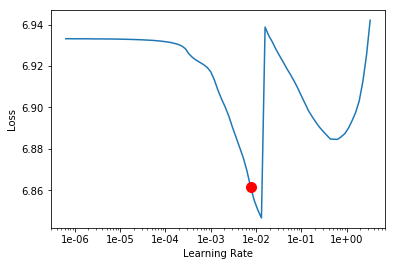

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.370264,2.372840,0.233079


# Part 2
200,000-400,000

In [24]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [25]:
learn.data = data

In [27]:
lr = 1e-2/1.35

In [28]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.332373,2.310076,0.255104


In [29]:
learn.save('mammal_in_training')

# Part 3

400,000-700,000

In [30]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [31]:
learn.data = data

In [33]:
lr = 1e-2/1.35**2

In [34]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.263601,2.244481,0.279138


In [35]:
learn.save('mammal_in_training')

# Part 4

700,000 - 1,000,000

In [36]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [37]:
learn.data = data

In [39]:
lr = 1e-2/1.35**3

In [40]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.244592,2.207216,0.293235


In [41]:
learn.save('mammal_in_training')

# Part 5

df 1,000,000 - 2,000,000

0-200,000

In [11]:
df = next(df_iter)

In [12]:
df.head()

,Sequence,Source,set
1000000,CATTGTTTTCATTCTCCATGACCGCTGTGGGTCACTTTCTATTATT...,NCBI Human,train
1000001,CACTTCAAAATGAAAAAATAATTATTGGAACTACATTGGGGGAACT...,NCBI Human,train
1000002,CAGTACAGCAGAATTCAAGGTCAGGGTAATTGCTTTCAGACAATAC...,NCBI Human,train
1000003,GATGGGGAAGAGTCAAGAACAGACAGCAGACGAGAAAAATAAATGA...,NCBI Human,train
1000004,AAGTAAATTGAAAACCTAGACAAGATTTTCCATTCTAGATGCCATT...,NCBI Human,train


In [19]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [20]:
learn.data = data

In [47]:
lr = 1e-2/1.35**4

In [48]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.234741,2.197642,0.297131


In [49]:
learn.save('mammal_in_training')

# Part 6

200,000 - 400,000

In [50]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [51]:
learn.data = data

In [53]:
lr = 1e-2/1.35**5

In [54]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.130705,2.186655,0.301050


In [55]:
learn.save('mammal_in_training')

In [22]:
learn.load('mammal_in_training');

# Part 7

400,000-700,000

In [23]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [24]:
learn.data = data

In [26]:
lr = 1e-2/1.35**6

In [28]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.213281,2.171236,0.306331


In [29]:
learn.save('mammal_in_training')

# Part 8

700,000 - 1,000,000

In [30]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [31]:
learn.data = data

In [33]:
lr = 1e-2/1.35**7

In [34]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.268297,2.164488,0.308762


In [35]:
learn.save('mammal_in_training')

# Part 9

df 2,000,000 - 3,000,000

0-200,000

In [13]:
df = next(df_iter)

In [14]:
df.head()

,Sequence,Source,set
2000000,CCCGGCAAGTGTTGCCAGTTTGAGGATGAGCATATGTCCTCAGTAG...,NCBI Pan Troglodytes,train
2000001,TCTACCCAAATCCTATAAAACGGCCCCACCCTTATCTCCCTTCGCT...,NCBI Pan Troglodytes,train
2000002,GAGGAGAGGTTTGTGAATAGCAGGAAGTAAGGTTAGGGCCAAAGAT...,NCBI Pan Troglodytes,train
2000003,GCCAGTCTCACTGATTTTCTTGAAACAAATTTCTTCCTTGACGATC...,NCBI Pan Troglodytes,train
2000004,TTCTTTTTGTTCCCCTGATCTCACCATAAGCATGTAGTCTTCTAAA...,NCBI Pan Troglodytes,train


In [38]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [39]:
learn.data = data

In [41]:
lr = 1e-2/1.35**8

In [42]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.255852,2.158983,0.310901


In [43]:
learn.save('mammal_in_training')

# Part 10

200,000 - 400,000

In [44]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [45]:
learn.data = data

In [47]:
lr = 1e-2/1.35**9

In [48]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.239419,2.156255,0.311763


In [49]:
learn.save('mammal_in_training')

# Part 11

400,000-700,000

In [50]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [51]:
learn.data = data

In [53]:
lr = 1e-2/1.35**10

In [54]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.231201,2.152693,0.313021


In [55]:
learn.save('mammal_in_training')

# Part 12

700,000 - 1,000,000

In [56]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [57]:
learn.data = data

In [59]:
lr = 1e-2/1.35**11

In [60]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.249343,2.148394,0.314563


In [61]:
learn.save('mammal_in_training')

In [22]:
learn.load('mammal_in_training');

# Part 13

df 3,000,000 - 4,000,000

0-200,000

In [15]:
df = next(df_iter)

In [16]:
df.head()

,Sequence,Source,set
3000000,GTACACACGGGGGCCTGTTAAAAGATCAGGGGTGGGAGGAGGGAGA...,NCBI Pan paniscus,train
3000001,GGGTTTATGTTTGAGGATGATTCTCTTTCTTGTCACCTTGGTGAGT...,NCBI Pan paniscus,train
3000002,TGCAACAGCTGTTAGGCACAGACTTGACTTTCAGGTTGTACAACGG...,NCBI Pan paniscus,train
3000003,TGCATAAACAATTCTTACATGAATAAATGGACACTTGTGCAGTGCA...,NCBI Pan paniscus,train
3000004,TATTTTGACTATGGAGTGCCCATTTAAATATCGTATTTCTTTCTTA...,NCBI Pan paniscus,train


In [25]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [26]:
learn.data = data

In [28]:
lr = 1e-2/1.35**12

In [30]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.268657,2.147511,0.314894


In [31]:
learn.save('mammal_in_training')

# Part 14

200,000 - 400,000

In [32]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [33]:
learn.data = data

In [35]:
lr = 1e-2/1.35**13

In [36]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.276500,2.146923,0.315151


In [37]:
learn.save('mammal_in_training')

# Part 15

400,000-700,000

In [38]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [39]:
learn.data = data

In [41]:
lr = 1e-2/1.35**14

In [42]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.274370,2.146069,0.315474


In [43]:
learn.save('mammal_in_training')

# Part 16

700,000 - 1,000,000

In [17]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [23]:
learn.data = data

In [25]:
lr = 1e-2/1.35**15

In [28]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.277253,2.145093,0.315823


In [29]:
learn.save('mammal_in_training')

# Part 17

df 4,000,000 - 

0-200,000

In [30]:
df = next(df_iter)

In [31]:
df.head()

,Sequence,Source,set
4000000,TTCAAAACATATCTAGTGAGCACATATTATGTAACAGGCTCAAAGG...,NCBI Gorilla gorilla gorilla,train
4000001,CCACCTAGTGGTCAAGTTTAGCAAAACTTTCTGGAGTCTATTGTTT...,NCBI Gorilla gorilla gorilla,train
4000002,CTCACACTGAAAATCATCATCAAAATGCAACATAATAATTATCTTC...,NCBI Gorilla gorilla gorilla,train
4000003,TTGTCAGCACACAGCGGTATCCAAGGTGCCTGGACTCTGTCAGGTT...,NCBI Gorilla gorilla gorilla,train
4000004,GTGGTTTGTAGTTCTCCTTGAAGAGGTCCTTCACGTCCCTTGTAAG...,NCBI Gorilla gorilla gorilla,train


In [32]:
df.shape

(713593, 3)

In [33]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [34]:
learn.data = data

In [36]:
lr = 1e-2/1.35**12

In [37]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.283294,2.145776,0.315523


In [38]:
learn.save('mammal_in_training')

# Part 14

200,000 - 400,000

In [39]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [40]:
learn.data = data

In [42]:
lr = 1e-2/1.35**13

In [43]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.295543,2.145157,0.315865


In [44]:
learn.save('mammal_in_training')

# Part 15

400,000-700,000

In [45]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:600000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [46]:
learn.data = data

In [48]:
lr = 1e-2/1.35**14

In [49]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.287086,2.144418,0.316144


In [50]:
learn.save('mammal_in_training')

# Part 16

700,000 - 713,593

In [51]:
data = GenomicTextLMDataBunch.from_df(path, df[600000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [52]:
learn.data = data

In [54]:
lr = 1e-2/1.35**15

In [55]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.232238,2.143400,0.316519


In [56]:
learn.save('mammal_in_training')

In [57]:
learn.save('mammal1')
learn.save_encoder('mammal1_enc')